## Notebook to run post processing of differential expression in single-cell data using glmmTMB

basically 
- read glmmTMB r script results per region and cell-type and then integrate them
- apply B&H FDR 
- take a look at overlap between brain regions and cell-types do some sample plotting

In [1]:
!date

#### import libraries and set notebook variables

In [2]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import statsmodels.stats.multitest as smm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import rc_context
import json

import warnings
warnings.simplefilter('ignore')

import random
random.seed(420)

import ray

In [3]:
# parameters
cohort = 'aging'
assay = 'RNA'

# directories for initial setup
home_dir = '/labshare/raph/datasets/adrd_neuro'
wrk_dir = f'{home_dir}/{cohort}'
quants_dir = f'{wrk_dir}/demux'
results_dir = f'{wrk_dir}/results'

# in files
# data_file = f'{quants_dir}/{cohort}.pegasus.leiden_085.Age_group_young_old.h5ad'
data_file = f'{quants_dir}/{cohort}.pegasus.leiden_085.subclustered.h5ad'
temp_name_remap_json = '{this_dir}/{name}_gene_name_remap_temp.csv'
temp_r_out_file = '{this_dir}/{chrt}.{name}_glmmtmb_results_temp.csv'
diffxpy_out_file = '{this_dir}/{name}_de_diffxpy.csv'

# out files
results_file = f'{results_dir}/{cohort}.glmmtmb_age_diffs.csv'
results_fdr_file = f'{results_dir}/{cohort}.glmmtmb_age_diffs_fdr.csv'
diffxpy_file = f'{results_dir}/{cohort}.diffxpy_age_diffs.csv'
diffxpy_fdr_file = f'{results_dir}/{cohort}.diffxpy_age_diffs_fdr.csv'

# constants
region_obs_feature = 'Brain_region'
celltype_obs_feature = 'new_anno'
broadtype_obs_feature = 'broad_celltype'
min_cell_count = 3
young_age_limit = 30.0
sns.set_theme(style='white', palette='Paired', font_scale=1.2) 

#### analysis functions

In [4]:
def read_diffxpy_results(group_name: str, group_type: str) -> pd.DataFrame:
    de_df = pd.read_csv(diffxpy_out_file.format(this_dir=quants_dir, 
                                                name=group_name.replace(" ", "_")), index_col=0)
    de_df['tissue'] = group_name
    if group_type == region_obs_feature:
        de_df['type'] = 'brain_region'
    elif group_type == celltype_obs_feature:
        de_df['type'] = 'cell_type'
    else:
        de_df['type'] = 'broad_type'
    return de_df

def read_feature_renamed_map(group_name: str) -> dict:
    # read dict from json file
    rename_cols = json.load(open(temp_name_remap_json.format(this_dir=quants_dir,
                                                             name=group_name.replace(" ", "_"))))
    return rename_cols

def reformat_glmmtmb_df(df: pd.DataFrame) -> pd.DataFrame:
    # reformat results into one row per feature
    temp_term = df.loc[df['term'] == 'old'].copy()
    temp_intercepts = df.loc[df['term'] == '(Intercept)', ['feature', 'estimate']].copy()
    temp_intercepts = temp_intercepts.rename(columns={'estimate': 'intercept'})
    this_df = temp_term.merge(temp_intercepts, how='inner', on='feature')
    return this_df[['feature', 'intercept', 'estimate', 'std.error', 'statistic', 'p.value']]

def read_glmmtmb_results(group_name: str, group_type: str, cols_to_rename: dict) -> pd.DataFrame:
    this_file = temp_r_out_file.format(this_dir=results_dir, chrt=cohort, 
                                       name=group_name.replace(" ", "_"))
    this_df = pd.read_csv(this_file)
    # need to flip the features with '-' -> '_' for R back to originals
    # the the key/values
    rename_cols = {value: key for (key, value) in cols_to_rename.items()}
    this_df['feature'] = this_df['feature'].replace(rename_cols)
    this_df = reformat_glmmtmb_df(this_df)
    this_df['tissue'] = group_name
    if group_type == region_obs_feature:
        this_df['type'] = 'brain_region'
    elif group_type == celltype_obs_feature:
        this_df['type'] = 'cell_type'
    else:
        this_df['type'] = 'broad_type'     
    return this_df

def compute_bh_fdr(df: pd.DataFrame, alpha: float=0.05, p_col: str='p.value',
                   method: str='fdr_bh', verbose: bool=True) -> pd.DataFrame:
    ret_df = df.copy()
    test_adjust = smm.multipletests(np.array(ret_df[p_col]), alpha=alpha, 
                                    method=method)
    ret_df[method] = test_adjust[1]
    if verbose:
        print(f'total significant after correction: {ret_df.loc[ret_df[method] < alpha].shape}')
    return ret_df

def plot_feature_by_age_group(df: pd.DataFrame, x_term: str, y_term: str):
    plt.figure(figsize=(9,9))
    sns.boxenplot(x=x_term,y=y_term, scale='exponential', data=df,
                  k_depth='trustworthy')

    grsplt = sns.stripplot(x=x_term,y=y_term, data=df, alpha=0.75,
                           jitter=True, color='darkgrey')
    plt.title(f'{y_term} ~ {x_term}', fontsize='large') 
    plt.xlabel(x_term)
    plt.ylabel(y_term)
    plt.show()
    
def plot_feature_by_sample(df: pd.DataFrame, x_term: str, y_term: str):
    # set up order by young then old
    temp = df.groupby('Age_group')['Sample_id'].unique()
    this_list = temp['young'].to_list() + temp['old'].to_list()    
    plt.figure(figsize=(9,9))
    sns.boxenplot(x='Sample_id',y=y_term, scale='exponential', data=df,
                  k_depth='trustworthy', hue=x_term, order=this_list)
    grsplt = sns.stripplot(x='Sample_id',y=y_term, data=df, alpha=0.75,
                           jitter=True, color='darkgrey', order=this_list)
    plt.xticks(rotation=75)
    plt.title(f'{y_term} ~ {x_term}', fontsize='large') 
    plt.xlabel('Sample')
    plt.ylabel(y_term)
    plt.show()    
    
def volcano_plot(df: pd.DataFrame, x_term: str='estimate', y_term: str='p.value', 
                 alpha: float=0.05, adj_p_col: str='fdr_bh', title: str=None, 
                 filter_nseeff: bool=True, extreme_size: float=10.0):
    if filter_nseeff:
        df = df.loc[((-extreme_size < df[x_term]) & 
                    (df[x_term] < extreme_size) &
                    (~df['statistic'].isna()) | 
                    (df[adj_p_col] < alpha))]
    plt.figure(figsize=(9,9))
    log_pvalue = -np.log10(df[y_term])
    is_sig = df[adj_p_col] < alpha
    sns.scatterplot(x=x_term, y=log_pvalue, data=df, hue=is_sig)
    plt.title(title)
    plt.xlabel('effect')
    plt.ylabel('-log10(p-value)')
    plt.show()
    
def prep_plot_feature(data: ad.AnnData, feature_results: pd.Series, 
                      group: str='old', filter_zeros: bool=False):
    if feature_results.type == 'brain_region':
        this_type = region_obs_feature
    elif feature_results.type == 'cell_type':
        this_type = celltype_obs_feature
    else:
        this_type = broadtype_obs_feature
    this_ad = subset_ad_by_type(data, feature_results.tissue, this_type)
    this_df = convert_ad_to_df(this_ad)
    if filter_zeros:
        this_df = this_df.loc[this_df[feature_results.feature] > 0]
    print(feature_results)
    sns.set_theme(style='white', palette='Paired', font_scale=1.2)
    plot_feature_by_age_group(this_df, group, feature_results.feature)
    plot_feature_by_sample(this_df, group, feature_results.feature)
    
def subset_ad_by_type(data: ad.AnnData, group_name: str, type_name: str,
                      reapply_filter: bool=True, min_cell_count: int=3,
                      verbose: bool=False) -> ad.AnnData:
    this_data = data[data.obs[type_name] == group_name].copy()
    shape_before = this_data.shape
    if reapply_filter:
        sc.pp.filter_genes(this_data, min_counts=min_cell_count)
        sc.pp.filter_cells(this_data, min_counts=min_cell_count)
        shape_after = this_data.shape
    if verbose:
        print(f'shape before and after: {shape_before} {shape_after}')
        print(this_data)
    return this_data

def convert_ad_to_df(data: ad.AnnData, young_age_limit: float=30.0, 
                     verbose: bool=False) -> pd.DataFrame:
    data_df = data.to_df()
    annots = data.obs[['Brain_region', 'Age','Age_group', 'pool_name', 
                       'Sample_id', 'Sex', 'donor_id']].copy()
    annots['old'] = np.where((annots['Age'] > young_age_limit), 1, 0)
    annots['female'] = np.where((annots['Sex'] == 'Female'), 1, 0)
    this_df = None
    if data_df.index.equals(annots.index):
        this_df = pd.concat([data_df, annots], axis='columns')
        if verbose:
            print(this_df.shape)
            display(this_df.head())
    return this_df

#### read the anndata (h5ad) file

In [5]:
%%time
adata = sc.read(data_file, cache=True)
print(adata)

Only considering the two last: ['.subclustered', '.h5ad'].
Only considering the two last: ['.subclustered', '.h5ad'].
AnnData object with n_obs × n_vars = 167945 × 35441
    obs: 'pool_name', 'Sample_id', 'Tissue_source', 'Brain_region', 'Clinical_diagnosis', 'Age', 'Sex', 'donor_id', 'lane_num', 'Channel', 'n_genes', 'n_counts', 'percent_mito', 'scale', 'Group', 'leiden_labels', 'anno', 'leiden_labels_085', 'new_anno', 'Age_group', 'broad_celltype'
    var: 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'
    uns: 'Channels', 'Groups', 'PCs', 'W_diffmap', 'W_pca_harmony', 'broad_celltype_colors', 'c2gid', 'df_qcplot', 'diffmap_evals', 'diffmap_knn_distances', 'diffmap_knn_indices', 'genome', 'gncells', 'leiden_resolution', 'modality', 'ncells', 'new_anno_colors', 'norm_count', 'pca', 'pca_features', 'pca_harmony_knn_distances', 'pca_harmony_knn_indices', 'stdzn_max_value', 'stdzn_mean', 'stdzn_std'
    obsm: 'X_diffmap', 'X_fle',

#### take a look at the cell counts by cell type

In [6]:
# get cell counts by 'categories'
categories = [region_obs_feature, celltype_obs_feature, broadtype_obs_feature]
for this_cat in categories:
    print(adata.obs[this_cat].value_counts())

Entorhinal cortex        54399
Putamen                  49625
Subventricular zone      36610
Middle temporal gyrus    27311
Name: Brain_region, dtype: int64
Oligodendrocyte-1    36479
SPN D1               15379
SPN D2               15280
Oligodendrocyte-2    12844
Astrocyte            11289
ExN CUX2 LAMP5        9055
uncertain             7548
InN ADARB2 VIP        7014
ExN FEZF2             6842
OPC                   6682
ExN RORB THEMIS       5130
InN LHX6 PVALB        4566
Microglia             3265
InN ADARB2 LAMP5      3216
ExN CUX2 ADARB2       3066
InN LHX6 SST          2937
uncertain-2           2677
SPN D1-2              2388
ExN RORB              1966
ExN LAMP5             1963
uncertain-3           1929
Ependymal             1853
Mural                 1293
Endothelial            953
Oligodendrocyte-3      806
Astrocyte-GFAP-Hi      599
SPN D2-2               465
ExN THEMIS             461
Radial Glia              0
Name: new_anno, dtype: int64
Oligodendrocyte      50129
SPN 

#### get sample counts per age group by  counts by 'categories'

In [7]:
# allow for more rows in output
prev_default = pd.get_option('max_rows')
pd.set_option('max_rows', 2000)

for this_cat in categories:
    print(adata.obs.groupby([this_cat,'Age_group'])['Sample_id'].nunique())
    
# restore default setting
pd.set_option('max_rows',prev_default)

Brain_region           Age_group
Entorhinal cortex      old          6
                       young        6
Middle temporal gyrus  old          7
                       young        5
Putamen                old          7
                       young        5
Subventricular zone    old          6
                       young        6
Name: Sample_id, dtype: int64
new_anno           Age_group
Astrocyte          old          26
                   young        22
Astrocyte-GFAP-Hi  old           0
                   young         1
Endothelial        old          26
                   young        22
ExN CUX2 ADARB2    old           8
                   young         8
ExN CUX2 LAMP5     old          24
                   young        20
ExN FEZF2          old          15
                   young        13
ExN LAMP5          old           7
                   young         6
ExN RORB           old           8
                   young         8
ExN RORB THEMIS    old          14
         

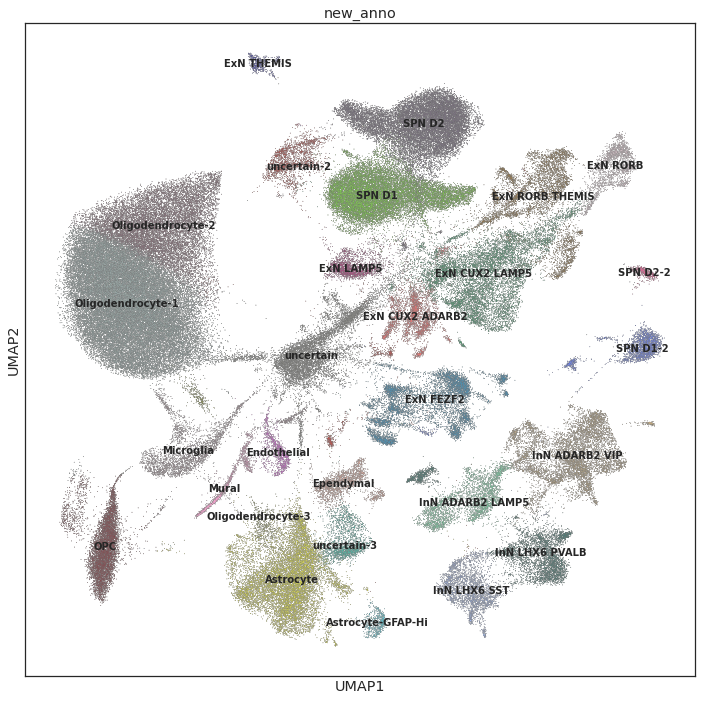

In [8]:
with rc_context({'figure.figsize': (12, 12)}):
    sc.pl.umap(adata, color=[celltype_obs_feature], legend_loc='on data', 
               add_outline=True, legend_fontsize=10)

##### find cell-types not used in analysis
remove them, and then refilter genes based on cell count

In [9]:
found_uncertain = [x for x in adata.obs[celltype_obs_feature].unique().to_list() 
                   if 'uncertain' in x] + ['Astrocyte-GFAP-Hi']
print(found_uncertain)
adata = adata[~adata.obs[celltype_obs_feature].isin(found_uncertain ), :]
sc.pp.filter_genes(adata, min_cells=min_cell_count)
adata

['uncertain', 'uncertain-2', 'uncertain-3', 'Astrocyte-GFAP-Hi']


Trying to set attribute `.var` of view, copying.


AnnData object with n_obs × n_vars = 155192 × 34596
    obs: 'pool_name', 'Sample_id', 'Tissue_source', 'Brain_region', 'Clinical_diagnosis', 'Age', 'Sex', 'donor_id', 'lane_num', 'Channel', 'n_genes', 'n_counts', 'percent_mito', 'scale', 'Group', 'leiden_labels', 'anno', 'leiden_labels_085', 'new_anno', 'Age_group', 'broad_celltype'
    var: 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'
    uns: 'Channels', 'Groups', 'PCs', 'W_diffmap', 'W_pca_harmony', 'broad_celltype_colors', 'c2gid', 'df_qcplot', 'diffmap_evals', 'diffmap_knn_distances', 'diffmap_knn_indices', 'genome', 'gncells', 'leiden_resolution', 'modality', 'ncells', 'new_anno_colors', 'norm_count', 'pca', 'pca_features', 'pca_harmony_knn_distances', 'pca_harmony_knn_indices', 'stdzn_max_value', 'stdzn_mean', 'stdzn_std'
    obsm: 'X_diffmap', 'X_fle', 'X_pca', 'X_pca_harmony', 'X_phi', 'X_umap', 'X_umap_085'
    varm: 'de_res', 'gmeans', 'gstds', 'means', 'partial_su

### read the diff by age results by region and cell-type

In [10]:
%%time
diffxpy_results = None
glmmtmb_results = None
# all_tissues = [adata.obs[this_cat].unique() for this_cat in categories]
# flattend = [item for sublist in all_tissues for item in sublist]
# print(flattend)
for this_type in categories:
    for this_tissue in adata.obs[this_type].unique():
        diffxpy_results = pd.concat([diffxpy_results, 
                                     read_diffxpy_results(this_tissue, this_type)])
        renamed_features = read_feature_renamed_map(this_tissue)
        glmmtmb_results = pd.concat([glmmtmb_results, 
                                     read_glmmtmb_results(this_tissue, this_type,
                                                          renamed_features)])

CPU times: user 17.1 s, sys: 165 ms, total: 17.2 s
Wall time: 17.2 s


In [11]:
print(diffxpy_results.shape)
display(diffxpy_results.head())
print(glmmtmb_results.shape)
display(glmmtmb_results.head())

(689622, 9)


gene          pval          qval    log2fc      mean  zero_mean  \
0     C9orf92  1.004041e-02  2.607008e-02  0.340583  0.036336      False   
1  AC116003.3  4.502621e-01  5.968537e-01  0.585765  0.001276      False   
2        HCN1  1.659567e-74  1.230964e-72 -0.202336  3.089777      False   
3  AL451166.1  2.114438e-02  5.011113e-02  0.593453  0.008754      False   
4       WDR63  3.482716e-01  4.943369e-01 -0.120797  0.046891      False   

   zero_variance                 tissue          type  
0          False  Middle temporal gyrus  brain_region  
1          False  Middle temporal gyrus  brain_region  
2          False  Middle temporal gyrus  brain_region  
3          False  Middle temporal gyrus  brain_region  
4          False  Middle temporal gyrus  brain_region

(299534, 8)


feature  intercept  estimate  std.error  statistic   p.value  \
0  AL627309.1  -3.532232  0.437769   0.198571   2.204596  0.027482   
1  AL627309.5  -2.466935  0.233767   0.148533   1.573841  0.115524   
2  AC114498.1  -9.307264  2.061367   1.253926   1.643931  0.100191   
3  AL669831.2  -5.156279 -0.736573   0.344991  -2.135051  0.032757   
4   LINC01409  -0.621747  0.135679   0.155248   0.873948  0.382147   

                  tissue          type  
0  Middle temporal gyrus  brain_region  
1  Middle temporal gyrus  brain_region  
2  Middle temporal gyrus  brain_region  
3  Middle temporal gyrus  brain_region  
4  Middle temporal gyrus  brain_region

In [12]:
diffxpy_results.groupby('type')['tissue'].value_counts()

type          tissue               
brain_region  Entorhinal cortex        31790
              Middle temporal gyrus    31153
              Putamen                  30604
              Subventricular zone      29078
broad_type    InN                      23998
              ExN                      22806
              Oligodendrocyte          21487
              SPN                      19226
              Astrocyte                18650
              OPC                      16425
              Microglia                15824
              Ependymal                11830
              Mural                    10913
              Endothelial               9464
cell_type     ExN RORB THEMIS          24395
              ExN FEZF2                21594
              ExN CUX2 ADARB2          21343
              ExN RORB                 20868
              InN ADARB2 VIP           20093
              Oligodendrocyte-1        19786
              InN LHX6 PVALB           19716
              Astro

In [13]:
glmmtmb_results.groupby('type')['tissue'].value_counts()

type          tissue               
brain_region  Subventricular zone      18066
              Putamen                  17236
              Entorhinal cortex        16025
              Middle temporal gyrus    14897
broad_type    InN                      15150
              ExN                      14810
              SPN                      13421
              Oligodendrocyte           9154
              Astrocyte                 6629
              Ependymal                 4601
              OPC                       4275
              Microglia                 4236
              Mural                     2220
              Endothelial               1242
cell_type     InN ADARB2 VIP           12338
              ExN CUX2 LAMP5           11613
              ExN RORB THEMIS          10836
              ExN CUX2 ADARB2          10789
              SPN D1                   10249
              InN LHX6 PVALB           10040
              SPN D2                    9828
              ExN F

#### compute the FDR values

In [14]:
glmmtmb_results['p.value'] = glmmtmb_results['p.value'].fillna(1)
glmmtmb_results = compute_bh_fdr(glmmtmb_results)
print(glmmtmb_results.shape)
display(glmmtmb_results.head())

diffxpy_results['pval'] = diffxpy_results['pval'].fillna(1)
diffxpy_results = compute_bh_fdr(diffxpy_results, p_col='pval')
print(diffxpy_results.shape)
display(diffxpy_results.head())

total significant after correction: (28548, 9)
(299534, 9)


feature  intercept  estimate  std.error  statistic   p.value  \
0  AL627309.1  -3.532232  0.437769   0.198571   2.204596  0.027482   
1  AL627309.5  -2.466935  0.233767   0.148533   1.573841  0.115524   
2  AC114498.1  -9.307264  2.061367   1.253926   1.643931  0.100191   
3  AL669831.2  -5.156279 -0.736573   0.344991  -2.135051  0.032757   
4   LINC01409  -0.621747  0.135679   0.155248   0.873948  0.382147   

                  tissue          type    fdr_bh  
0  Middle temporal gyrus  brain_region  0.123209  
1  Middle temporal gyrus  brain_region  0.265975  
2  Middle temporal gyrus  brain_region  0.245341  
3  Middle temporal gyrus  brain_region  0.134740  
4  Middle temporal gyrus  brain_region  0.549119

total significant after correction: (253819, 10)
(689622, 10)


gene          pval          qval    log2fc      mean  zero_mean  \
0     C9orf92  1.004041e-02  2.607008e-02  0.340583  0.036336      False   
1  AC116003.3  4.502621e-01  5.968537e-01  0.585765  0.001276      False   
2        HCN1  1.659567e-74  1.230964e-72 -0.202336  3.089777      False   
3  AL451166.1  2.114438e-02  5.011113e-02  0.593453  0.008754      False   
4       WDR63  3.482716e-01  4.943369e-01 -0.120797  0.046891      False   

   zero_variance                 tissue          type        fdr_bh  
0          False  Middle temporal gyrus  brain_region  2.981847e-02  
1          False  Middle temporal gyrus  brain_region  6.067767e-01  
2          False  Middle temporal gyrus  brain_region  2.278467e-72  
3          False  Middle temporal gyrus  brain_region  5.622591e-02  
4          False  Middle temporal gyrus  brain_region  5.083623e-01

#### count of significant genes by brain region

In [15]:
glmmtmb_results.loc[glmmtmb_results['fdr_bh'] < 0.05].groupby('type')['tissue'].value_counts()

type          tissue               
brain_region  Subventricular zone       767
              Entorhinal cortex         508
              Putamen                   433
              Middle temporal gyrus     363
broad_type    InN                      2684
              OPC                      1214
              Oligodendrocyte          1214
              ExN                      1060
              Astrocyte                 902
              Microglia                 797
              SPN                       503
              Ependymal                 160
              Mural                     158
              Endothelial               100
cell_type     InN LHX6 PVALB           1910
              InN ADARB2 VIP           1657
              Oligodendrocyte-1        1403
              InN LHX6 SST             1297
              ExN FEZF2                1250
              OPC                      1214
              ExN RORB THEMIS          1039
              ExN RORB                 1

In [16]:
diffxpy_results.loc[diffxpy_results['fdr_bh'] < 0.05].groupby('type')['tissue'].value_counts()

type          tissue               
brain_region  Subventricular zone      16522
              Putamen                  15380
              Entorhinal cortex        14816
              Middle temporal gyrus    12926
broad_type    InN                      13744
              ExN                      13533
              SPN                      12367
              Oligodendrocyte           7724
              Astrocyte                 5362
              Ependymal                 3555
              OPC                       3138
              Microglia                 3036
              Mural                     1444
              Endothelial                727
cell_type     InN ADARB2 VIP           10951
              ExN CUX2 LAMP5           10526
              SPN D1                    9304
              ExN CUX2 ADARB2           9211
              ExN RORB THEMIS           9017
              SPN D2                    8909
              InN LHX6 PVALB            8454
              ExN F

#### save the full results

In [17]:
glmmtmb_results.to_csv(results_file, index=False)
diffxpy_results.to_csv(diffxpy_file, index=False)

#### save the statistically significant results

In [18]:
glmmtmb_results.loc[glmmtmb_results['fdr_bh'] < 0.05].to_csv(results_fdr_file, index=False)
diffxpy_results.loc[diffxpy_results['fdr_bh'] < 0.05].to_csv(diffxpy_fdr_file, index=False)

In [19]:
display(glmmtmb_results.loc[glmmtmb_results['fdr_bh'] < 0.05].head())
display(diffxpy_results.loc[diffxpy_results['fdr_bh'] < 0.05].head())

feature  intercept  estimate  std.error  statistic   p.value  \
8    LINC02593  -6.588815 -1.979733   0.640648  -3.090203  0.002000   
12       ISG15  -2.851665 -0.478886   0.168812  -2.836799  0.004557   
56       MEGF6  -3.358775  0.310553   0.095130   3.264499  0.001097   
175      EPHA8  -4.230609  0.914316   0.303745   3.010140  0.002611   
183      ASAP3  -1.604814  0.322646   0.087524   3.686370  0.000227   

                    tissue          type    fdr_bh  
8    Middle temporal gyrus  brain_region  0.031302  
12   Middle temporal gyrus  brain_region  0.048795  
56   Middle temporal gyrus  brain_region  0.022328  
175  Middle temporal gyrus  brain_region  0.036201  
183  Middle temporal gyrus  brain_region  0.008847

gene          pval          qval    log2fc      mean  zero_mean  \
0   C9orf92  1.004041e-02  2.607008e-02  0.340583  0.036336      False   
2      HCN1  1.659567e-74  1.230964e-72 -0.202336  3.089777      False   
7     ITIH4  9.906897e-07  4.911355e-06 -0.215145  0.297815      False   
8    WDSUB1  1.416847e-04  5.301348e-04  0.077437  1.093028      False   
10     FKRP  2.081517e-06  9.947155e-06 -0.217022  0.305604      False   

    zero_variance                 tissue          type        fdr_bh  
0           False  Middle temporal gyrus  brain_region  2.981847e-02  
2           False  Middle temporal gyrus  brain_region  2.278467e-72  
7           False  Middle temporal gyrus  brain_region  6.557768e-06  
8           False  Middle temporal gyrus  brain_region  6.608425e-04  
10          False  Middle temporal gyrus  brain_region  1.316573e-05

#### visualize volcano plots

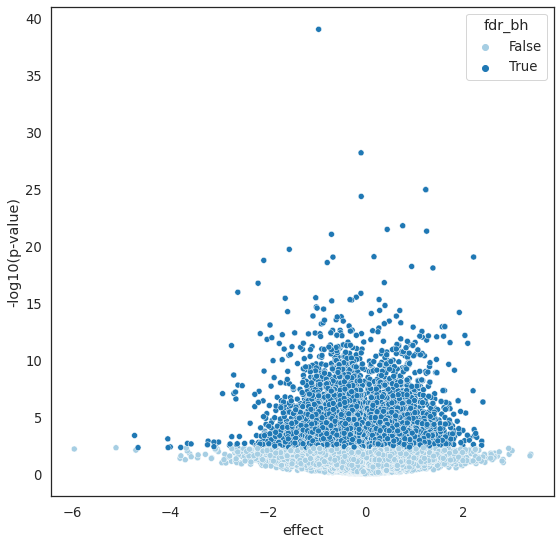

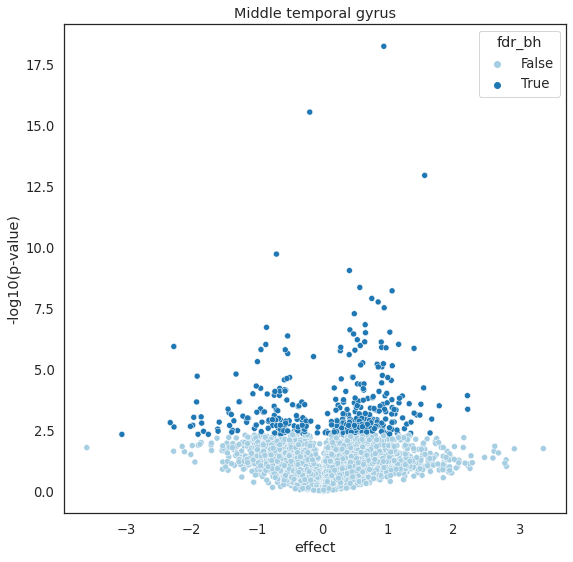

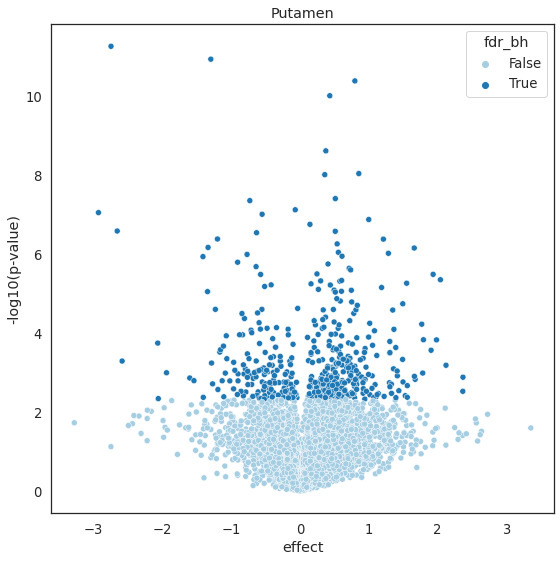

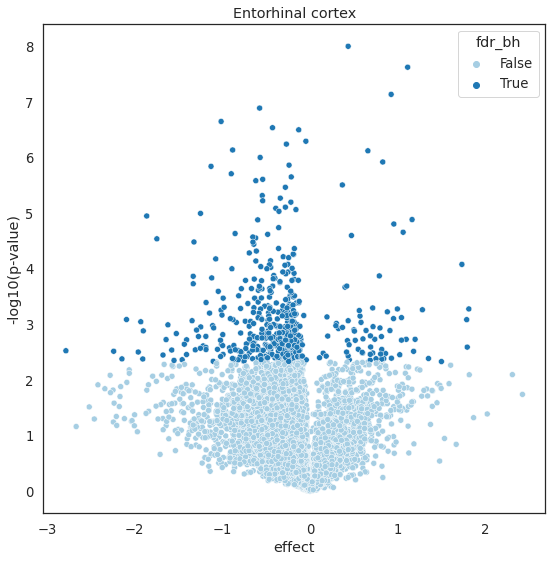

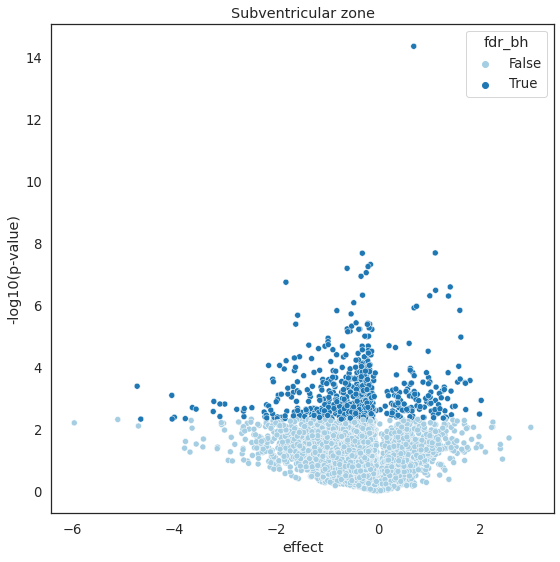

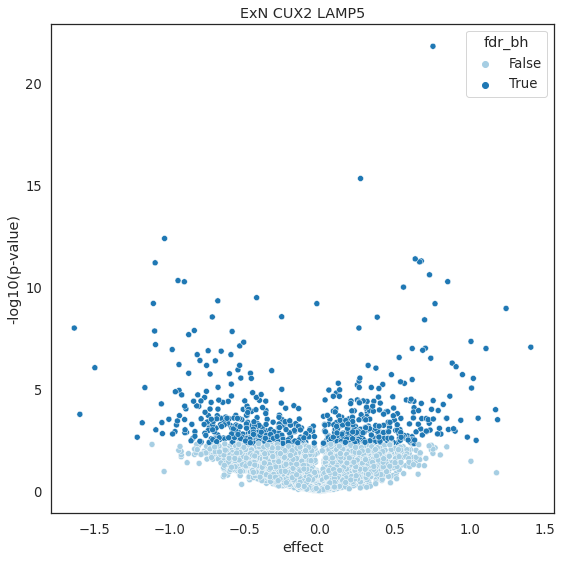

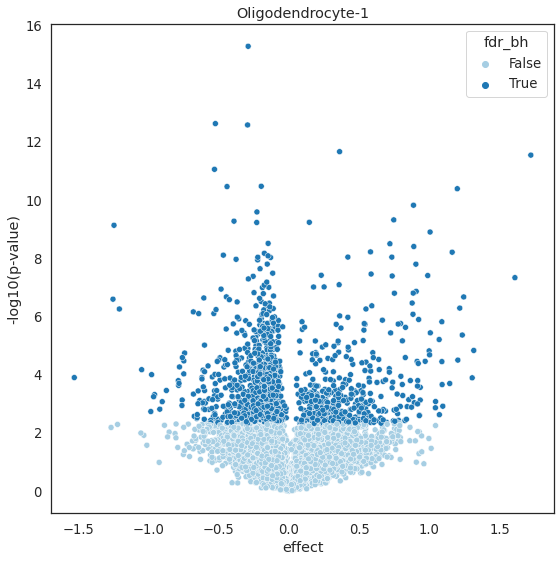

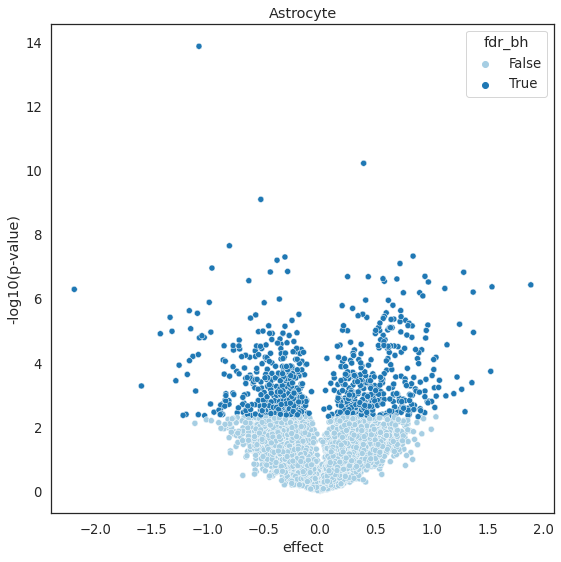

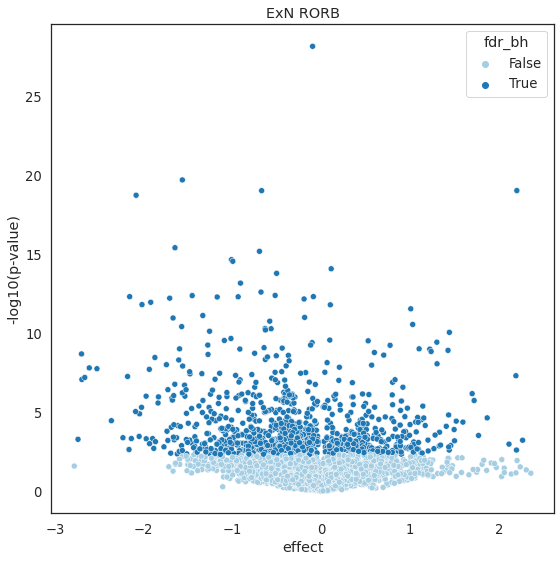

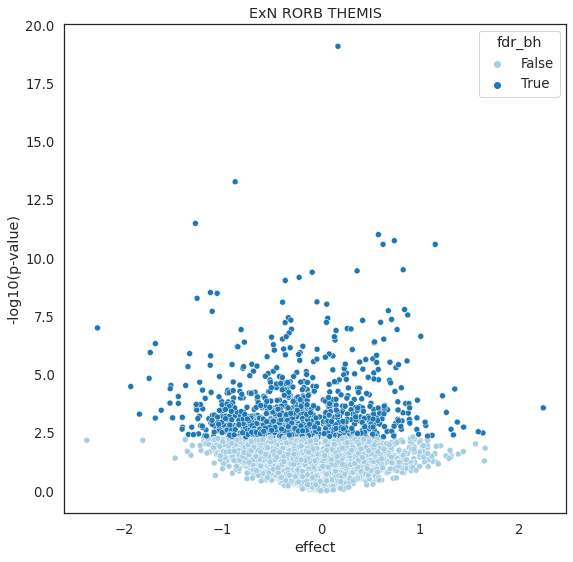

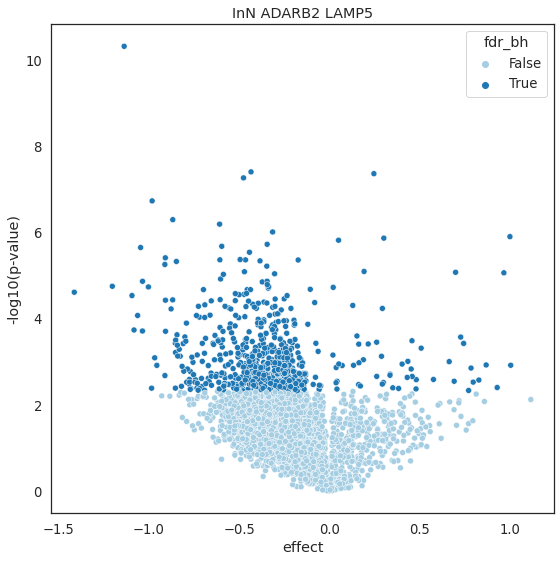

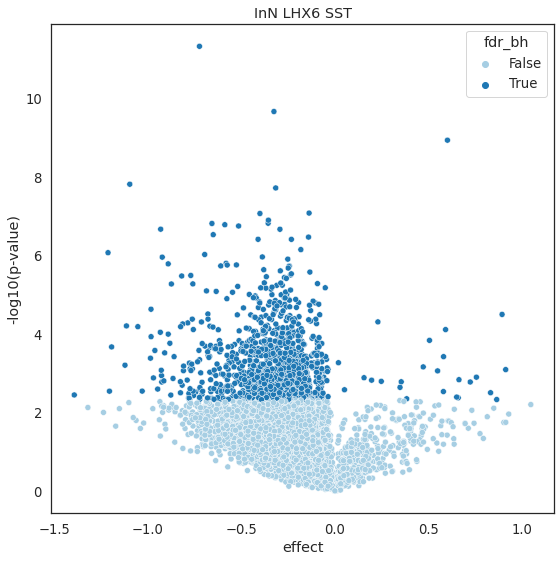

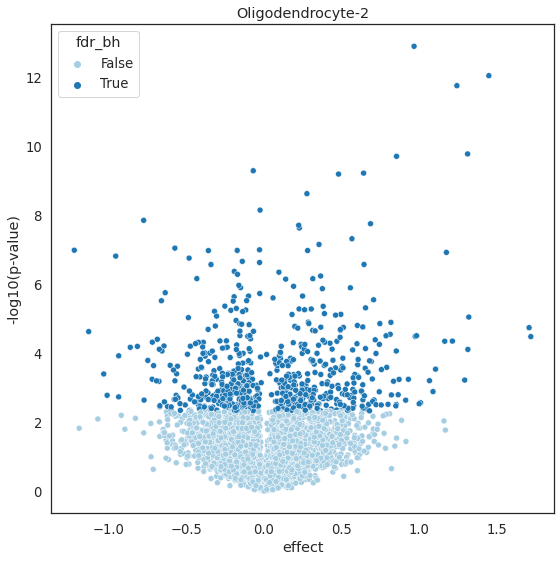

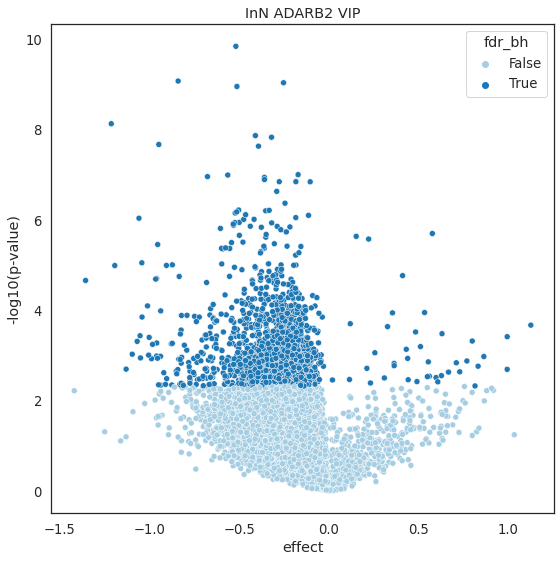

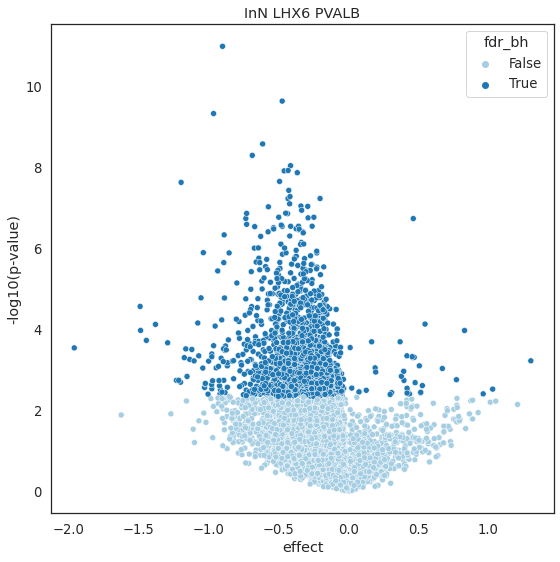

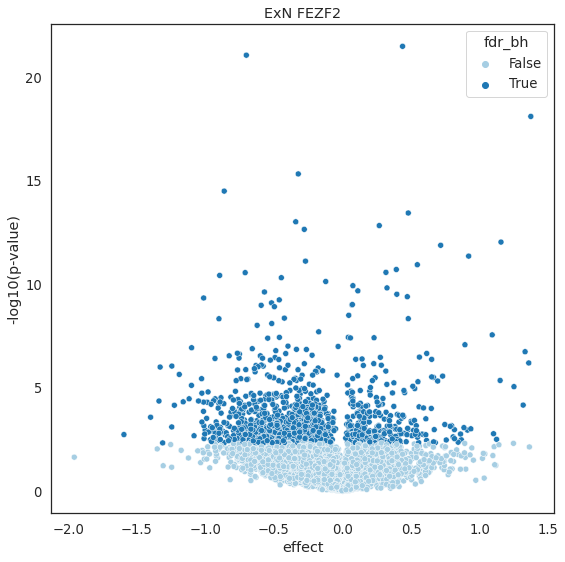

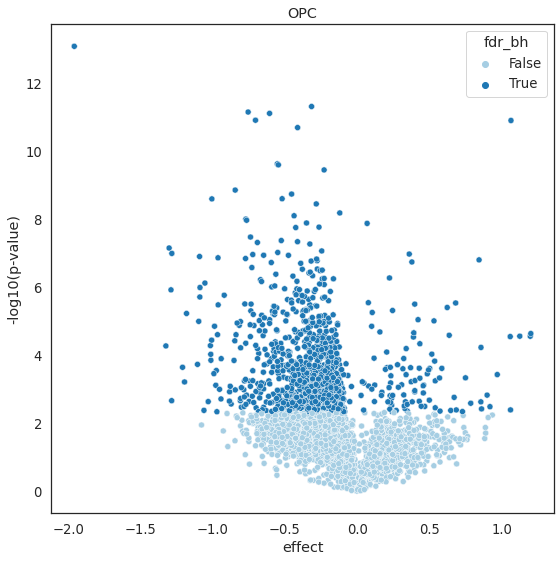

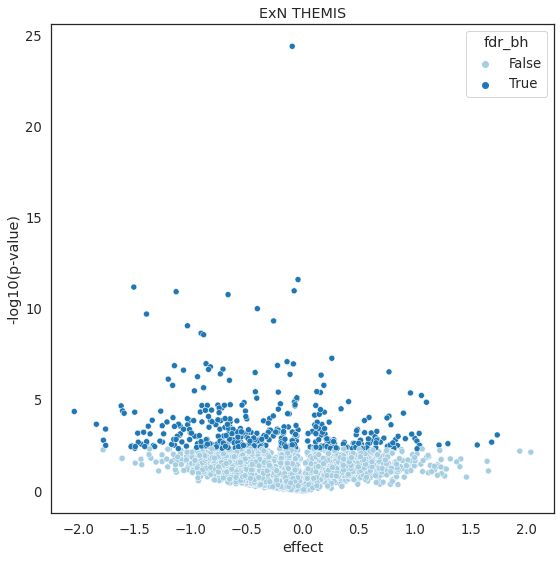

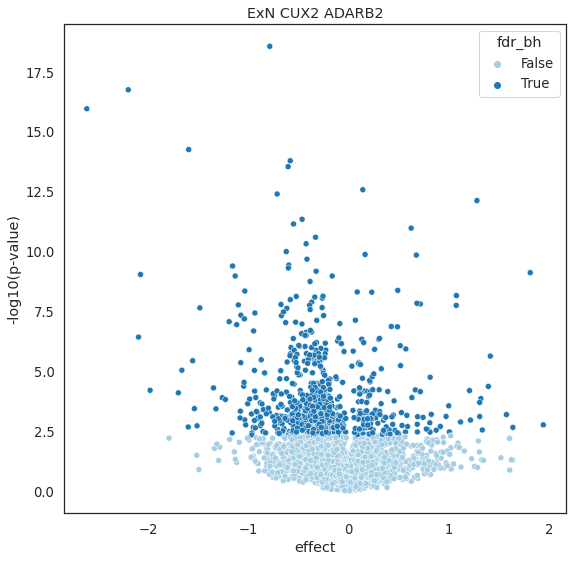

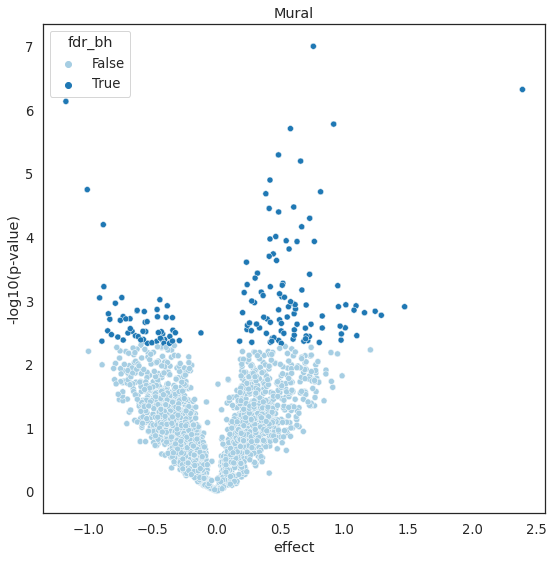

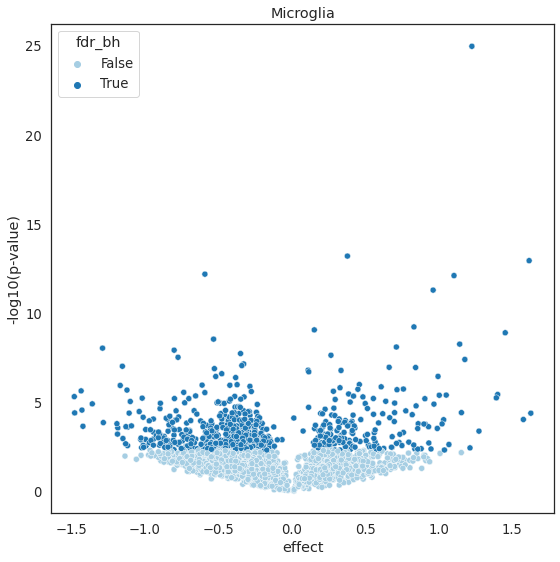

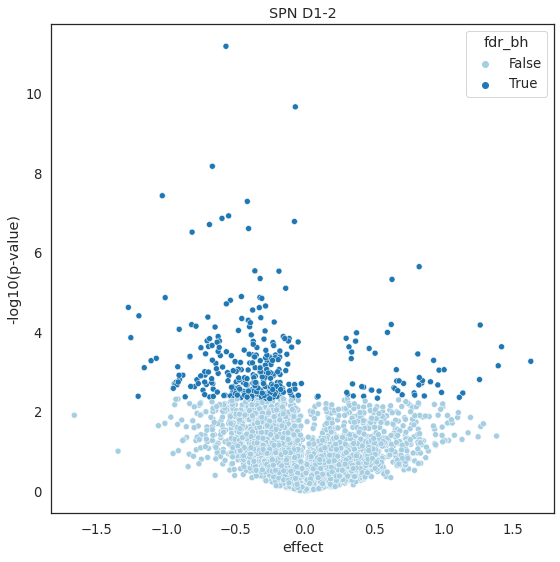

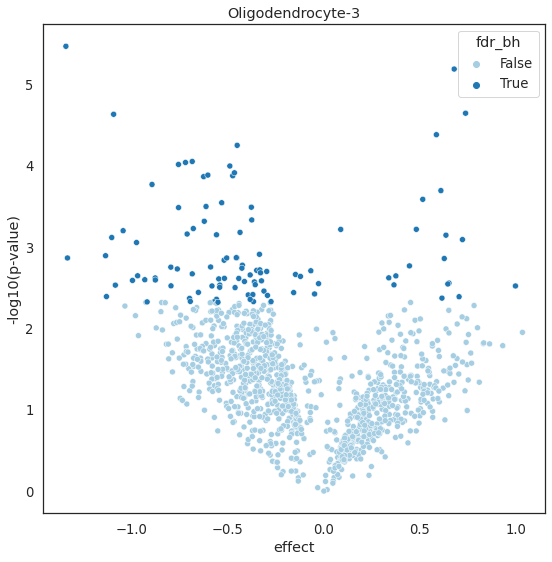

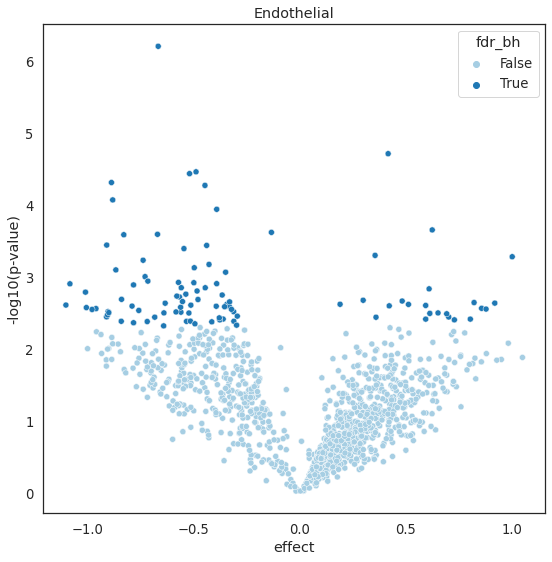

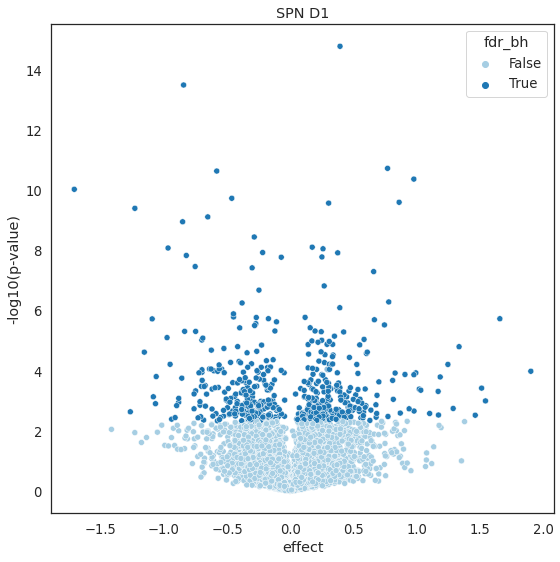

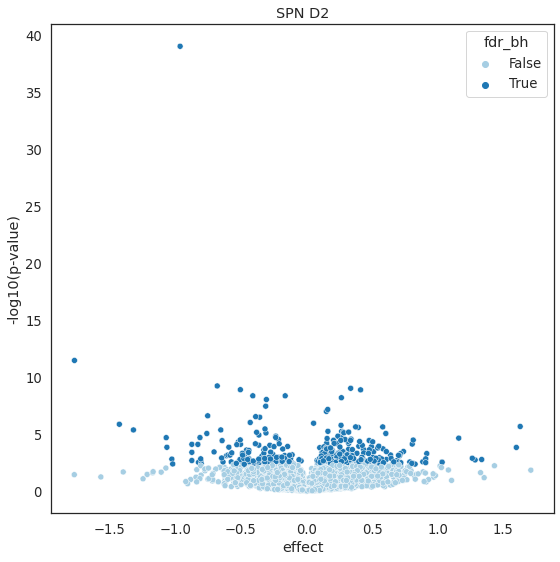

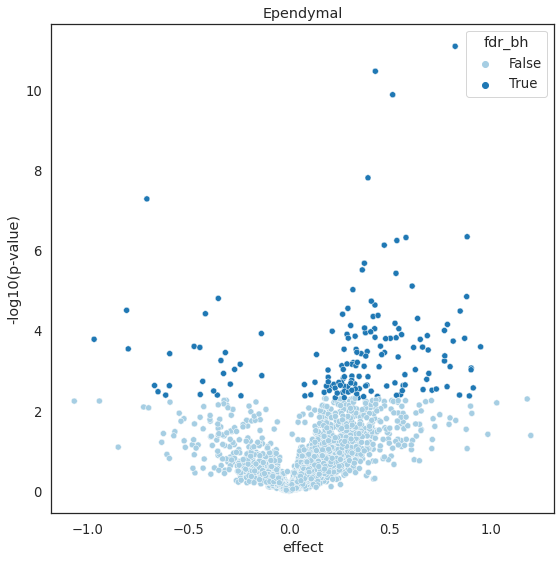

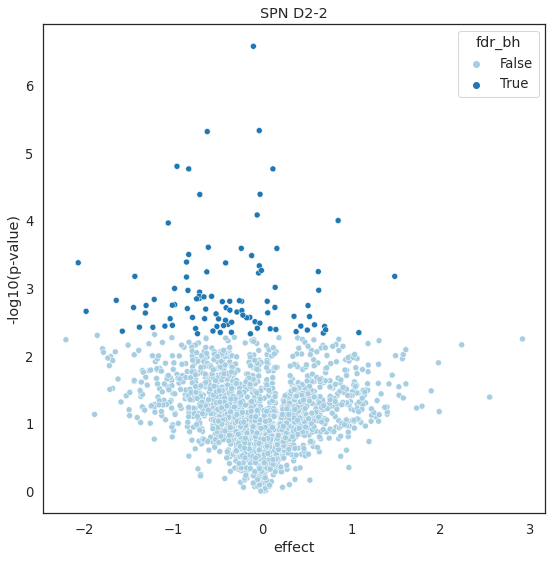

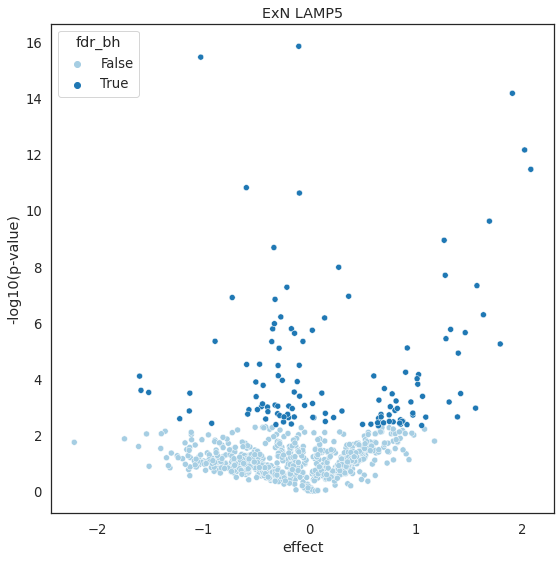

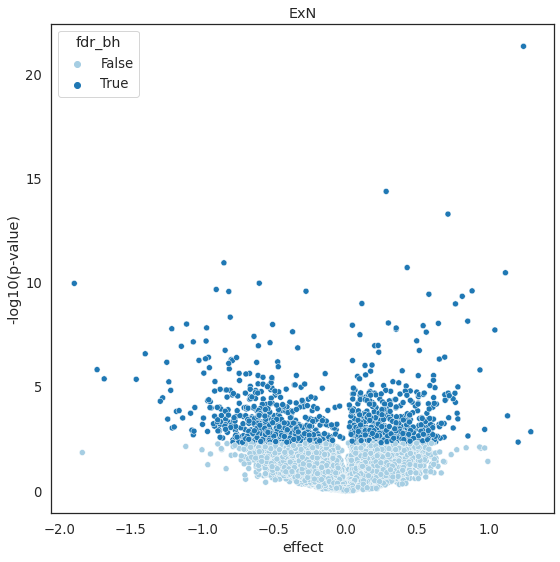

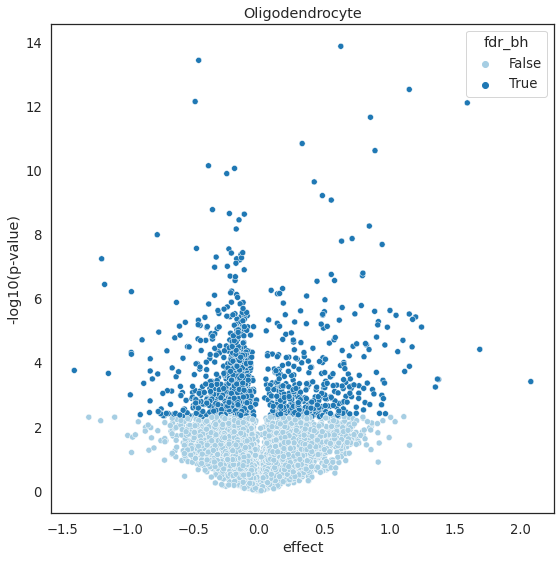

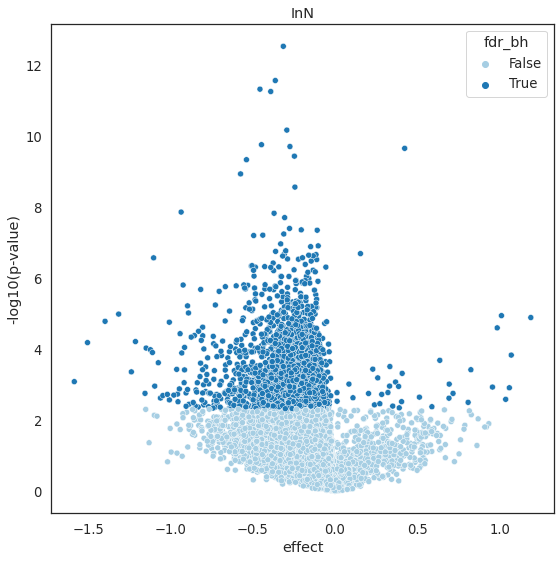

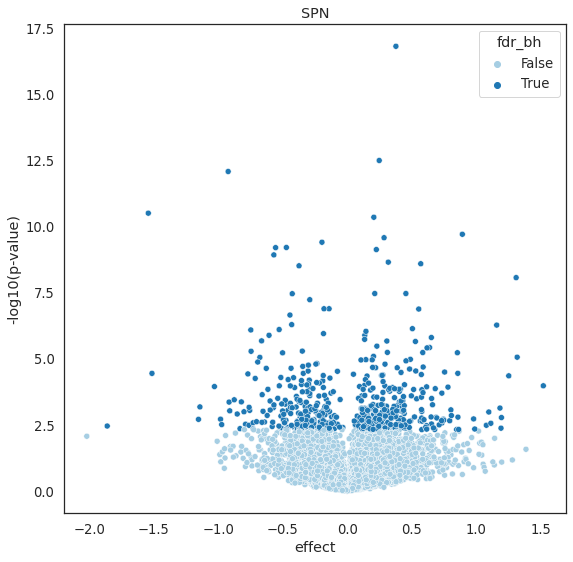

In [20]:
volcano_plot(glmmtmb_results)

for tissue in glmmtmb_results['tissue'].unique():
    volcano_plot(glmmtmb_results.loc[glmmtmb_results['tissue'] == tissue], title=tissue)

In [21]:
glmmtmb_results.head()

feature  intercept  estimate  std.error  statistic   p.value  \
0  AL627309.1  -3.532232  0.437769   0.198571   2.204596  0.027482   
1  AL627309.5  -2.466935  0.233767   0.148533   1.573841  0.115524   
2  AC114498.1  -9.307264  2.061367   1.253926   1.643931  0.100191   
3  AL669831.2  -5.156279 -0.736573   0.344991  -2.135051  0.032757   
4   LINC01409  -0.621747  0.135679   0.155248   0.873948  0.382147   

                  tissue          type    fdr_bh  
0  Middle temporal gyrus  brain_region  0.123209  
1  Middle temporal gyrus  brain_region  0.265975  
2  Middle temporal gyrus  brain_region  0.245341  
3  Middle temporal gyrus  brain_region  0.134740  
4  Middle temporal gyrus  brain_region  0.549119

#### look at some of the individual results

feature          PREX1
intercept    -0.306855
estimate     -0.963413
std.error     0.072995
statistic   -13.198372
p.value            0.0
tissue          SPN D2
type         cell_type
fdr_bh             0.0
Name: 9058, dtype: object


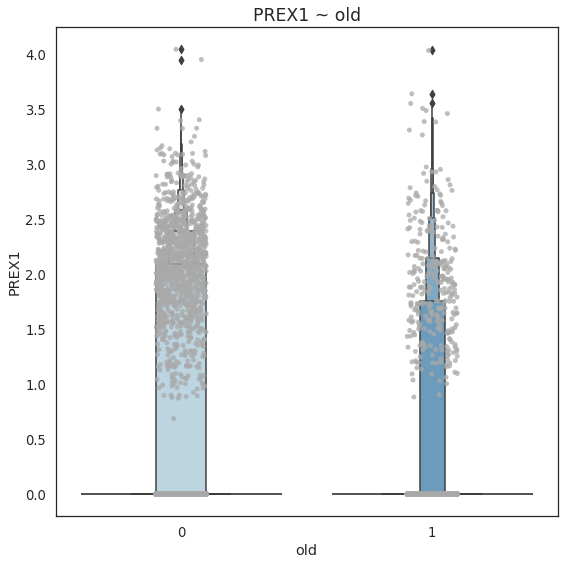

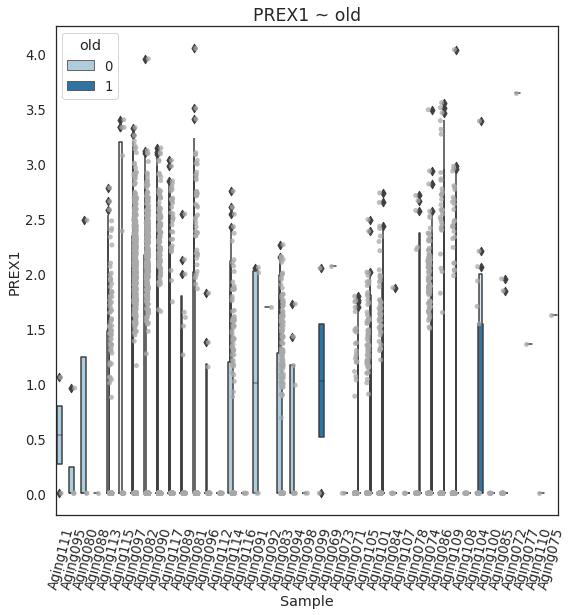

feature          PREX1
intercept    -0.306855
estimate     -0.963413
std.error     0.072995
statistic   -13.198372
p.value            0.0
tissue          SPN D2
type         cell_type
fdr_bh             0.0
Name: 9058, dtype: object


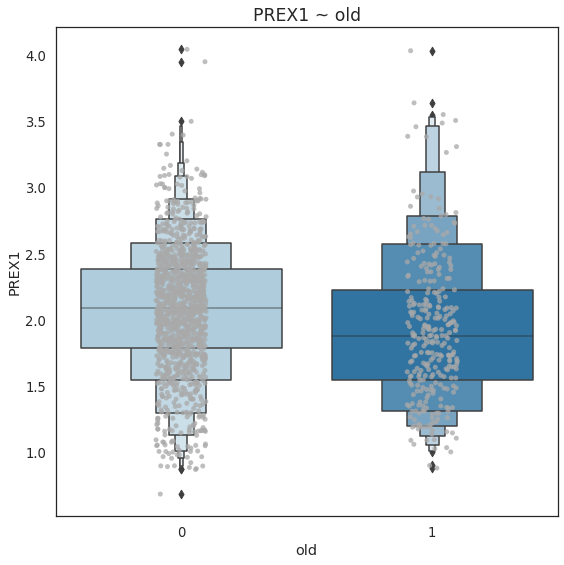

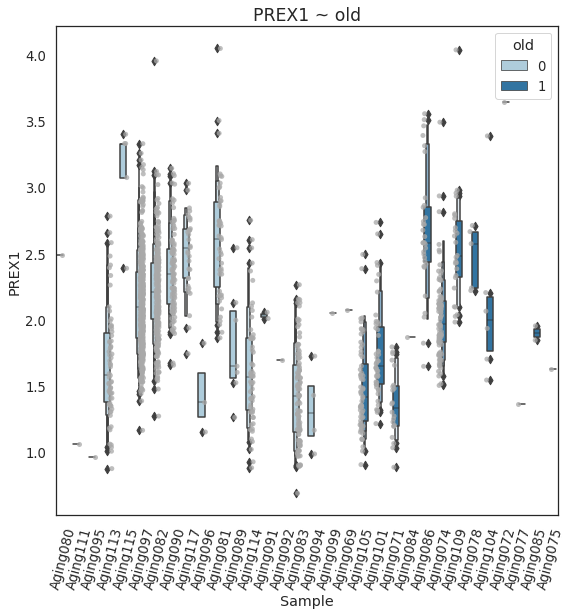

In [23]:
# max significant by p-value
this_results = glmmtmb_results.loc[glmmtmb_results['p.value'] == min(glmmtmb_results['p.value'])]
this_hit = this_results.sort_values(by=['estimate'], ascending=False).iloc[0]
prep_plot_feature(adata, this_hit)
prep_plot_feature(adata, this_hit, filter_zeros=True)

feature      AC119673.2
intercept     -3.103338
estimate       2.394442
std.error      0.475349
statistic      5.037228
p.value             0.0
tissue            Mural
type          cell_type
fdr_bh         0.000129
Name: 162, dtype: object


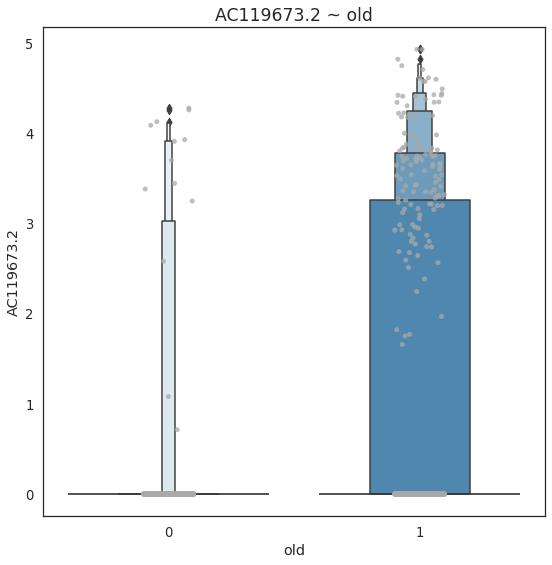

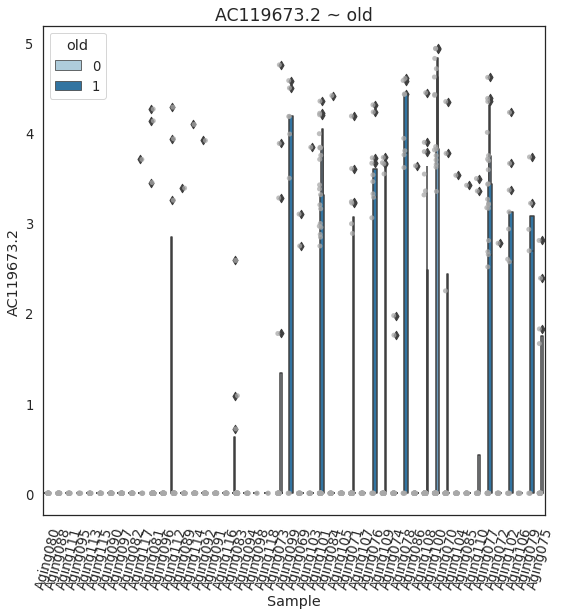

feature      AC119673.2
intercept     -3.103338
estimate       2.394442
std.error      0.475349
statistic      5.037228
p.value             0.0
tissue            Mural
type          cell_type
fdr_bh         0.000129
Name: 162, dtype: object


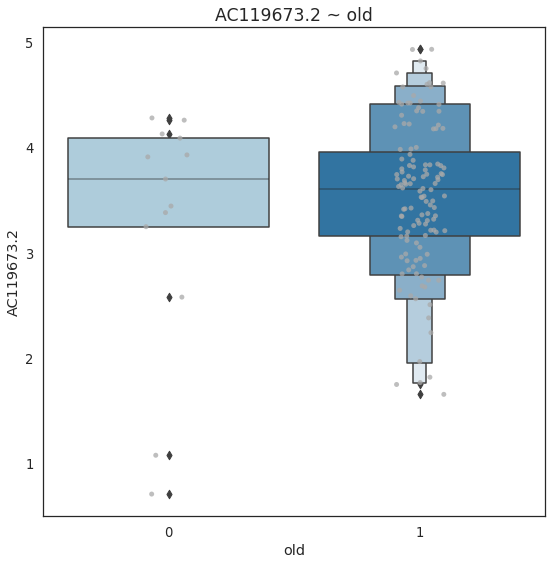

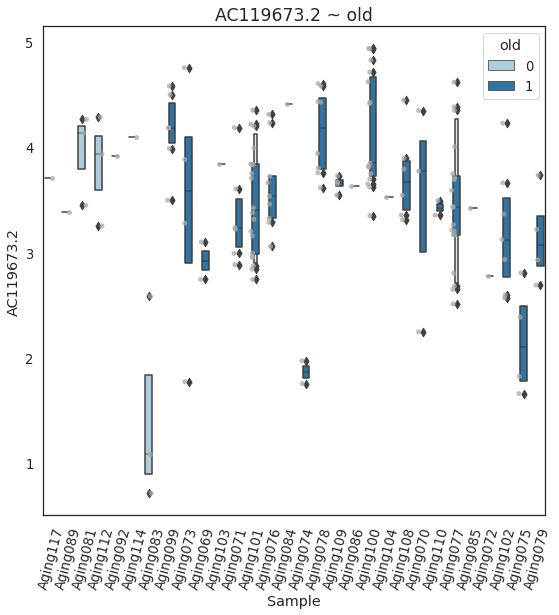

In [24]:
# max significant by estimate (increasing)
sig_results = glmmtmb_results.loc[glmmtmb_results['fdr_bh'] < 0.05]
this_results = sig_results.loc[sig_results['estimate'] == max(sig_results['estimate'])]
this_hit = this_results.sort_values(by=['estimate'], ascending=False).iloc[0]
prep_plot_feature(adata, this_hit)
prep_plot_feature(adata, this_hit, filter_zeros=True)

feature                GGT7
intercept          0.489868
estimate          -0.157784
std.error          0.049485
statistic         -3.188556
p.value             0.00143
tissue       InN ADARB2 VIP
type              cell_type
fdr_bh             0.025893
Name: 11327, dtype: object


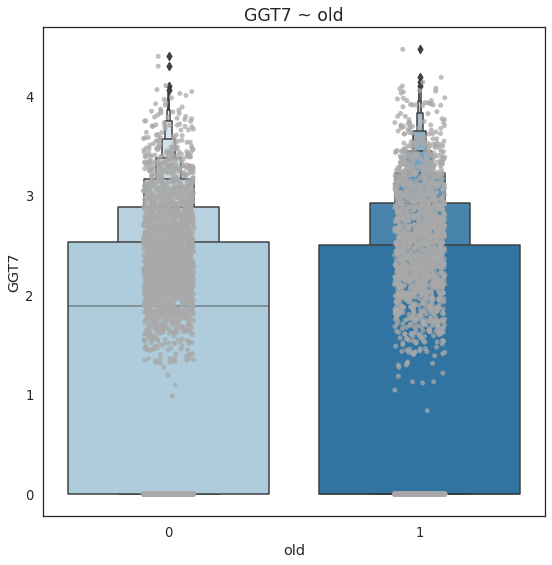

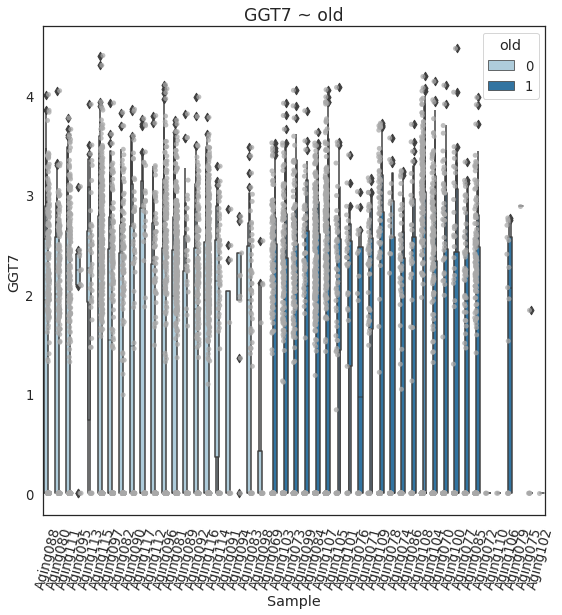

feature                GGT7
intercept          0.489868
estimate          -0.157784
std.error          0.049485
statistic         -3.188556
p.value             0.00143
tissue       InN ADARB2 VIP
type              cell_type
fdr_bh             0.025893
Name: 11327, dtype: object


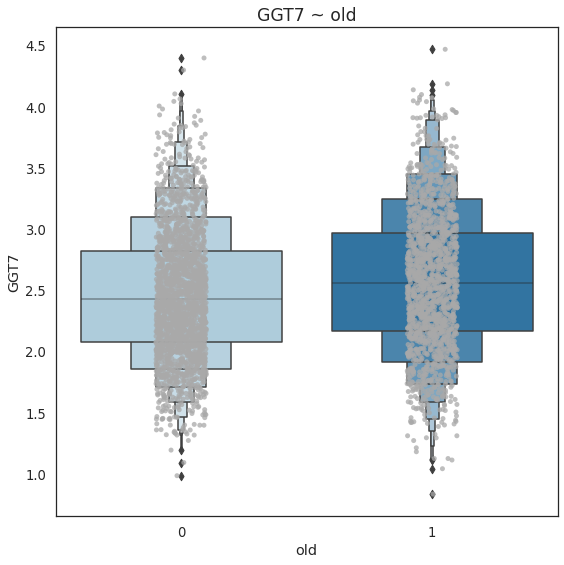

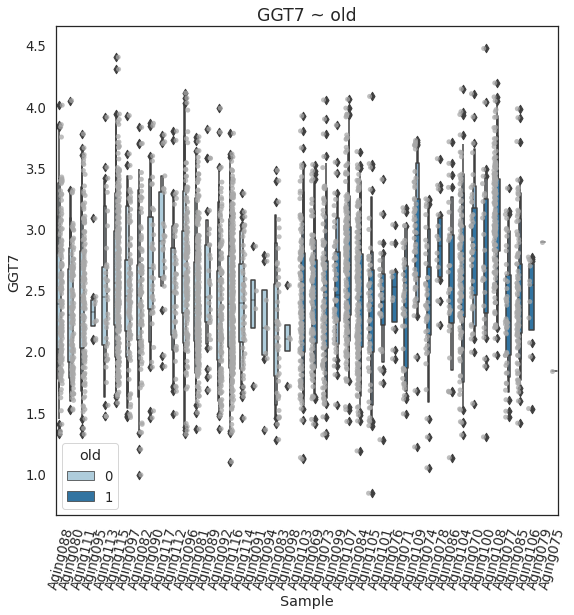

In [25]:
# random
this_hit = sig_results.sample().iloc[0]
prep_plot_feature(adata, this_hit)
prep_plot_feature(adata, this_hit, filter_zeros=True)

feature               AGA
intercept      -24.085516
estimate        22.323139
std.error    14033.819599
statistic        0.001591
p.value          0.998731
tissue           SPN D2-2
type            cell_type
fdr_bh                1.0
Name: 539, dtype: object


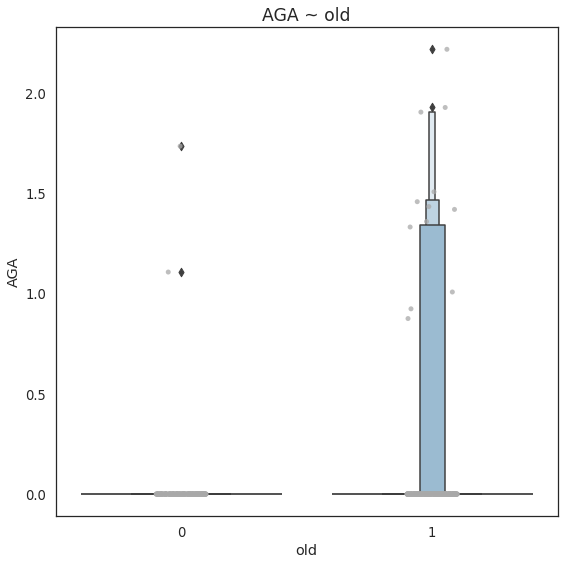

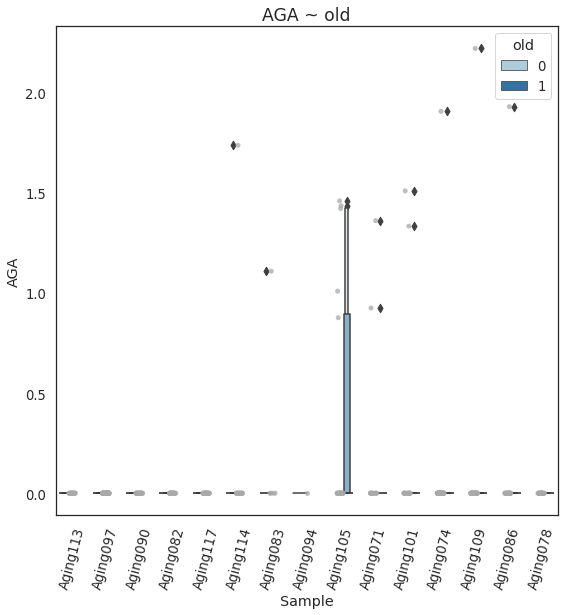

feature               AGA
intercept      -24.085516
estimate        22.323139
std.error    14033.819599
statistic        0.001591
p.value          0.998731
tissue           SPN D2-2
type            cell_type
fdr_bh                1.0
Name: 539, dtype: object


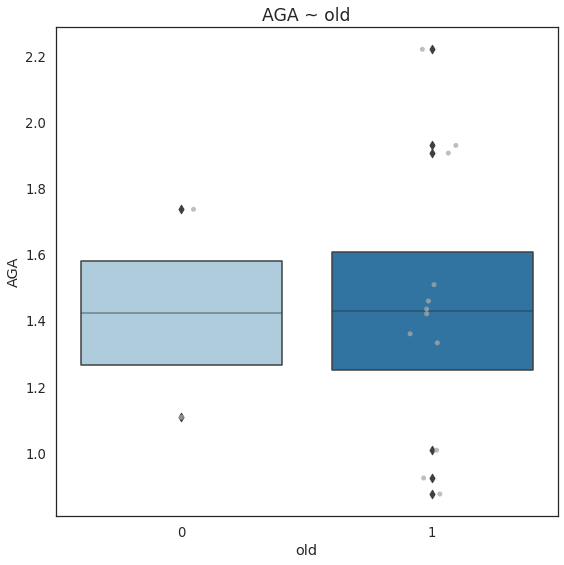

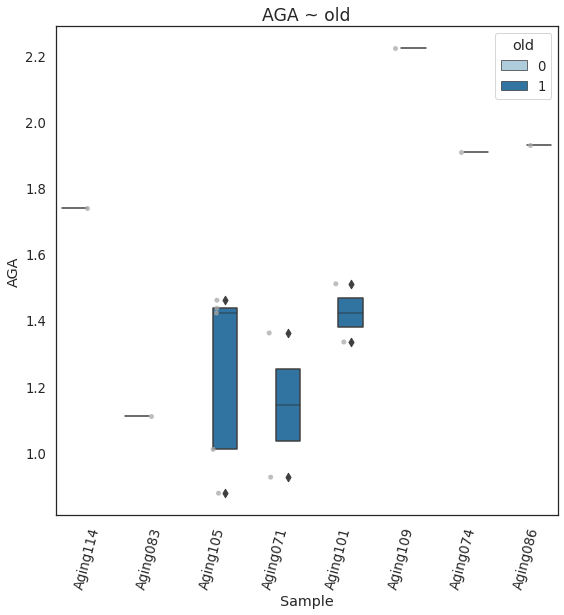

In [26]:
# max non-significat by coef (increasing)
nonsig_results = glmmtmb_results.loc[(glmmtmb_results['fdr_bh'] > 0.05) & 
                                     (~glmmtmb_results['statistic'].isna())]
this_results = nonsig_results.loc[nonsig_results['estimate'] == max(nonsig_results['estimate'])]
this_hit = this_results.sort_values(by=['estimate'], ascending=True).iloc[0]
prep_plot_feature(adata, this_hit)
prep_plot_feature(adata, this_hit, filter_zeros=True)